In [1]:
!nvidia-smi

Sun Jun 13 18:17:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.5.1+cu101 in /usr/local/lib/python3.7/dist-packages (1.5.1+cu101)
Requirement already up-to-date: torchvision==0.6.1+cu101 in /usr/local/lib/python3.7/dist-packages (0.6.1+cu101)
  Using cached https://files.pythonhosted.org/packages/d1/e7/19e84e2223fa997dfb9a0b5fbbb0c91889577ef029acca9448d8e7cc6d74/mmcv-full-1.3.6.tar.gz
  Using cached https://files.pythonhosted.org/packages/6a/00/b08f23b7d7e1e14ce01419a467b583edbb93c6cdb8654e54a9cc579cd61f/addict-2.4.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/0d/8814e79eb865eab42d95023b58b650d01dec6f8ea87fc9260978b1bf2167/yapf-0.31.0-py2.py3-none-any.whl
  Created wheel for mmcv-full: filename=mmcv_full-1.3.6-cp37-cp37m-linux_x86_64.whl size=25694369 sha256=74c0a3dbacc5d4d6a8fb86fa92b174bc18fb9a5f9b76456cb6d5e6ec5b5c62c5
  Stored in directory: /root/.cache/pip/wheels/2e/3d/3e/2ea1242e99b67cc9b86d1cec48c7545ec

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
print(torch.__version__, torch.cuda.is_available())
import mmdet
print(mmdet.__version__)
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import glob
import random
import time
from google.colab.patches import cv2_imshow

1.5.1+cu101 True
2.13.0
11.0
GCC 7.5


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
config_file = '/content/drive/MyDrive/be_final_project/faster_rcnn_r50_fpn_3x_gtsdb_1cat.py' #'/content/drive/MyDrive/be project/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco-traffic_sign.py'
checkpoint_file = '/content/drive/MyDrive/be_final_project/epoch_80.pth'
device = 'cuda:0'
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# init a detector
model_det = init_detector(config_file, checkpoint_file, device=device)
model_rec = torch.load('/content/drive/MyDrive/be_final_project/TSR27.pt')  #('/content/drive/MyDrive/be project/model_12.pt')   
model_rec.eval()
model_rec.to('cuda')
#dict_cat={0: 'animals', 1: 'bend', 2: 'bend left', 3: 'bend right', 4: 'construction', 5: 'cycles crossing', 6: 'danger', 7: 'give way',8: 'go left', 9: 'go left or straight', 10: 'go right', 11: 'go right or straight', 12: 'go straight', 13: 'keep left', 14: 'keep right', 15: 'no entry', 16: 'no overtaking', 17: 'no overtaking (trucks)', 18: 'no traffic both ways', 19: 'no trucks', 20: 'pedestrian crossing', 21: 'priority at next intersection', 22: 'priority road', 23: 'restriction ends', 24: 'restriction ends (overtaking trucks)', 25: 'restriction ends (overtaking)', 26: 'restriction ends 80', 27: 'road narrows',28: 'roundabout', 29: 'school crossing', 30: 'slippery road', 31: 'snow', 32: 'speed limit 100', 33: 'speed limit 120', 34: 'speed limit 20', 35: 'speed limit 30', 36: 'speed limit 50', 37: 'speed limit 60', 38: 'speed limit 70', 39: 'speed limit 80', 40: 'stop', 41: 'traffic signal', 42: 'uneven road' }
#dict_cat={0: 'NOT Recognized' , 1: '50 to 100 meters' , 2: '200 meters' , 3: 'Cross Road' , 4: 'Gap in Median' , 5: 'Hump' , 6: 'Left hand curve' , 7: 'Major road ahed' , 8: 'Men at Work' , 9: 'Narrow Bridge' , 10: 'Pedestrain' , 11: 'Right hand curve' , 12: 'School Ahead' , 13: 'Side Road Left' , 14: 'Side Road Right' , 15: 'Slippery Road' , 16: 'Staggered Intersection' , 17: 'Y intersection' }
dict_cat={0: 'NOT Recognized' , 1: '50 to 100 meters' , 2: '200 meters' , 3: 'Cross Road' , 4: 'Gap in Median' , 5: 'Hump' , 6: 'Left hand curve' , 7: 'Major road ahed' , 8: 'Men at Work' , 9: 'Narrow Bridge' , 10: 'Pedestrain' , 11: 'Right hand curve' , 12: 'School Ahead' , 13: 'Side Road Left' , 14: 'Side Road Right' , 15: 'Slippery Road' , 16: 'Speed Limit 50' , 17:'Speed Limit 80', 18: 'Staggered Intersection' , 19: 'Y intersection' }

Use load_from_local loader


In [10]:
def Check(sign):
    L20=[8,10,12,15,19]
    L30=[3,4,9,18]
    L40=[1,2,6,7,11,13,14]
    temp = 2147483647
    per = 2147483647
    if sign in L20:
      temp = 20
    elif sign in L30:
      temp = 30
    elif sign in L40:
      temp = 40
    elif sign==5:           #for hump/speed breaker - sign 5
      temp = 15
    if sign==16:
      per = 50
    elif sign==17:
      per = 80
    return temp, per

def Area(points):
  return (points[2]-points[0])*(points[3]-points[1])

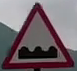

Hump


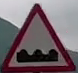

Hump


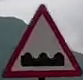

Hump


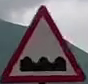

Hump


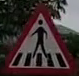

Pedestrain


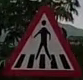

Pedestrain


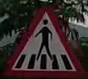

Pedestrain


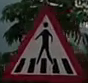

Pedestrain


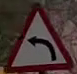

Left hand curve


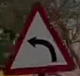

Left hand curve


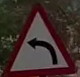

Left hand curve


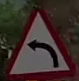

Left hand curve


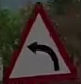

Left hand curve


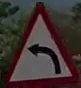

Left hand curve


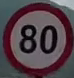

Speed Limit 80


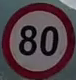

Speed Limit 80


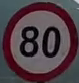

Speed Limit 80


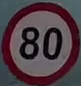

Speed Limit 80


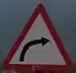

Right hand curve


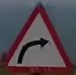

Right hand curve


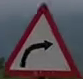

Right hand curve


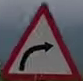

Right hand curve


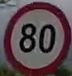

Speed Limit 80


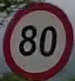

Speed Limit 80


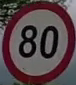

Speed Limit 80


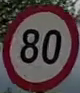

Speed Limit 80


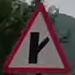

Side Road Right


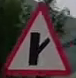

Side Road Right


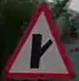

Side Road Right


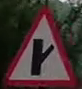

Side Road Right


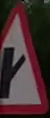

Side Road Right


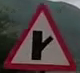

Side Road Right


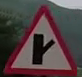

Side Road Right


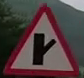

Side Road Right


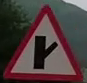

Side Road Right


In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/content/drive/MyDrive/be_final_project/video_2.mp4')
result_vid = cv2.VideoWriter('/content/drive/MyDrive/be_final_project/opVid_final_35.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 30, (int(cap.get(3)), int(cap.get(4))))
speed=35
glob_speed_limit=300
glob_count=150
per_speedlimit = 100

if (cap.isOpened()== False):
  print("Error opening video stream or file")   # Check if camera opened successfully

while(cap.isOpened()):    # Read until video is completed
  ret, frame = cap.read() # Capture frame-by-frame
  if ret == True:
    result = inference_detector(model_det, frame)
    #frame = model_det.show_result(frame, result, score_thr=0.5)
    rec_out=[]
    for _ in range(len(result[0])):
      #print(frame.shape)
      #print(result[0][_])
      #print(Area(result[0][_]))
      if Area(result[0][_]) < 7500 and Area(result[0][_]) > 5400:
        image = frame[int(result[0][_][1]):int(result[0][_][3]), int(result[0][_][0]):int(result[0][_][2])]
        cv2_imshow(np.asarray(image))
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)

        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')

        with torch.no_grad():
            output = model_rec(input_batch)

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

        prob, catid = torch.topk(probabilities, 1)
        #print(prob, catid)
        rec_out.append(catid)
        if catid < 43:
          print(dict_cat[int(catid[0])])
        frame = cv2.rectangle(frame, (result[0][_][0], result[0][_][1]), (result[0][_][2], result[0][_][3]), (0, 0, 255), 2)
        frame = cv2.putText(frame, dict_cat[int(catid[0])], (result[0][_][0], result[0][_][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (255, 0, 0), 1, cv2.LINE_AA)
    if len(rec_out)!=0:
      temp_speedlimit = 2147483647
      for x in rec_out:
        temp, per = Check(x)
        temp_speedlimit = min(temp_speedlimit, temp)
        if per != 2147483647:
          per_speedlimit = per
      if glob_speed_limit > temp_speedlimit:
        glob_speed_limit=temp_speedlimit
        glob_count=150
    if speed > per_speedlimit:
      frame = cv2.putText(frame, 'ALERT!! Safety Speed limit '+ str(per_speedlimit), (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    if speed > glob_speed_limit and glob_count!=0:
    #print("ALERT!!! Slow down to "+ str(speedlimit))
      frame = cv2.putText(frame, 'ALERT!! Slow down to '+ str(glob_speed_limit), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
      glob_count-=1
    if glob_count==0:
      glob_speed_limit=300
      glob_count=150
    #clear_output(wait=True)
    #cv2_imshow(frame) # Display the resulting frame
    result_vid.write(frame)
  else:
    break  # Break the loop
# When everything done, release the video capture object
cap.release()
result_vid.release()